In [1]:
# pip install --user sklearn
import sys
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
#! pip install --user pandas
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

## 1. Levantamos el dataset

In [2]:

fake = pd.read_csv("../archive/Fake.csv")
true = pd.read_csv("../archive/True.csv")

# ponemos los dos en uno
fake["label"] = 1
true["label"] = 0
df = pd.concat([fake, true], ignore_index = True)
print(df.title)

0         Donald Trump Sends Out Embarrassing New Year’...
1         Drunk Bragging Trump Staffer Started Russian ...
2         Sheriff David Clarke Becomes An Internet Joke...
3         Trump Is So Obsessed He Even Has Obama’s Name...
4         Pope Francis Just Called Out Donald Trump Dur...
                               ...                        
44893    'Fully committed' NATO backs new U.S. approach...
44894    LexisNexis withdrew two products from Chinese ...
44895    Minsk cultural hub becomes haven from authorities
44896    Vatican upbeat on possibility of Pope Francis ...
44897    Indonesia to buy $1.14 billion worth of Russia...
Name: title, Length: 44898, dtype: object


## 2. Preprocesamiento: limpiamos el texto

In [3]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    # agregar otras...
    return text

df.title = df.title.map(clean_text)
df.text = df.text.map(clean_text)

## 3. Vectorizamos el texto

Hicimos la experimentación utilizando dos vectorizadores de texto distintos:
- Count Vectorizer, que simplemente cuenta la cantidad de apariciones de cada palabra.
- Term Frequency Inverse Document Frequency, que incrementa proporcionalmente con la cantidad de apariciones de la palabra pero contrarresta con el número de documentos en el que está presente, permitiendo así que las palabras demasiado frecuentes y sin valor semántico no sean un problema.

In [4]:
USE_COUNT_VECTORIZER = True # Con este parametro controlamos cual vectorizador usar

In [5]:
# removemos palabras con muy alta o muy baja frecuencia. ademas, removemos las "stop words" del inglés
# (palabras como 'the', 'a', 'he', 'her', etc.)
def vectorize_text(dataframe):
    MAX_FREQ_THRESHOLD = 0.8
    MIN_FREQ_THRESHOLD = 0.003
    kwargs = {
        'stop_words': 'english',
        'max_df': MAX_FREQ_THRESHOLD,
        'min_df': MIN_FREQ_THRESHOLD
    }
    # DOCS: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    vect = CountVectorizer(**kwargs) if USE_COUNT_VECTORIZER else TfidfVectorizer(**kwargs)
    data_vectorized_titles = vect.fit_transform(dataframe.title)
    # print(cv.get_feature_names())  # vocabulario
    # print(len(cv.get_feature_names())) # tamaño del vocabulario
    data_dtm = pd.DataFrame(data_vectorized_titles.toarray(), columns=vect.get_feature_names())
    data_dtm.index = dataframe.index
    return data_dtm

data_dtm = vectorize_text(df)
data_dtm

,act,action,ad,administration,admits,adviser,agency,ahead,aid,aide,...,wont,work,workers,working,world,wow,year,years,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Análisis exploratorio de datos

### 4.1 ¿Cuáles son las palabras más frecuentes en los títulos de cada tipo de noticia?

#### Palabras más frecuentes en las noticias falsas

In [6]:
data_fake = data_dtm[:len(fake)]
data_fake = data_fake.transpose()
data_fake_top = data_fake.sum(axis=1).sort_values(ascending=False)[:60]
fake_dict = list(zip(data_fake_top.index, map(round, data_fake_top.values)))
fake_dict[:10]

[('trump', 7216),
 ('video', 3229),
 ('watch', 1890),
 ('obama', 1809),
 ('hillary', 1765),
 ('trumps', 1467),
 ('just', 1399),
 ('president', 1075),
 ('clinton', 964),
 ('new', 893)]

#### Palabras más frecuentes en las noticias verdaderas

In [7]:
data_true = data_dtm[len(fake):len(fake)+len(true)]
data_true = data_true.transpose()
data_true_top = data_true.sum(axis=1).sort_values(ascending=False)[:60]
true_dict = list(zip(data_true_top.index, map(round, data_true_top.values)))

"""
Esto es truchisimo pero estamos sacando la palabra que mas aparece que es 'says'
"""
true_dict.pop(1) 
true_dict[:10]

[('trump', 4734),
 ('house', 1437),
 ('north', 924),
 ('new', 875),
 ('white', 815),
 ('korea', 804),
 ('russia', 804),
 ('senate', 739),
 ('court', 711),
 ('trumps', 683)]

#### Y para visualizarlo un poco más lindo, usemos un WordCloud:

     |████████████████████████████████| 371 kB 868 kB/s eta 0:00:01


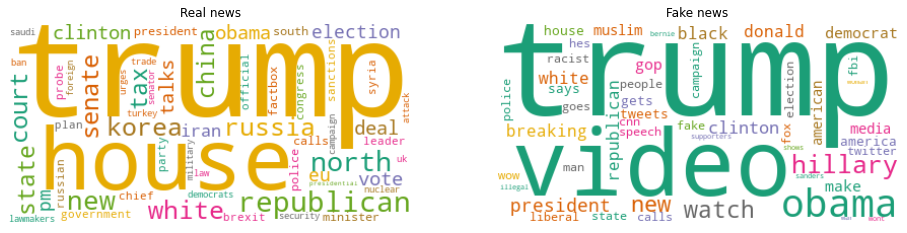

In [10]:
!pip install WordCloud
from wordcloud import WordCloud

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, collocations=False)

# Reset the output dimensions
import matplotlib.pyplot as plt

data_true_str = ''.join([(x[0] + ' ')*x[1] for x in true_dict])
data_fake_str = ''.join([(x[0] + ' ')*x[1] for x in fake_dict])
plt.rcParams['figure.figsize'] = [16, 6]
titles = ['Real news', 'Fake news']
data = [data_true_str, data_fake_str]
# Create subplots for each comedian
for index, data_str in enumerate(data):
    wc.generate(data[index])
    
    plt.subplot(1,2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titles[index])
    
plt.show()

- Las palabras que vemos tienen todas un buen valor semántico, indicando que el preprocesamiento del texto que hicimos es bueno. 
- Parecería que las noticias falsas tienen que ver con temas sociales
- Y que las noticias verdaderas hablan más de economía y política internacional.

## 5. Downsample del dataset
Hacemos esto para que la experimentación dure menos, pero lo vamos a desactivar para reportar los resultados finales.

In [11]:
# Parametros de config
DO_DOWNSAMPLE = True
DOWNSAMPLING_SIZE=8000

if DO_DOWNSAMPLE:
    dtm_fake_downsampled = resample(data_fake.transpose(), n_samples=int(DOWNSAMPLING_SIZE/2), random_state=42)
    dtm_true_downsampled = resample(data_true.transpose(), n_samples=int(DOWNSAMPLING_SIZE/2), random_state=42)

dtm_downsampled = pd.concat([dtm_fake_downsampled, dtm_true_downsampled])
dtm_downsampled

,act,action,ad,administration,admits,adviser,agency,ahead,aid,aide,...,wont,work,workers,working,world,wow,year,years,york,young
15795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6. Partimos el dataset en un conjunto de training y otro de testing

In [12]:
if DO_DOWNSAMPLE:
    Y = np.array([1]*int(DOWNSAMPLING_SIZE/2) + [0]*int(DOWNSAMPLING_SIZE/2))
    X = dtm_downsampled.to_numpy()
else:
    Y = df['label'].to_numpy()
    X = data_dtm.to_numpy()
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

#Si estamos usando el Count vectorizer debemos normalizar el texto. Notar que vectorizamos el test sin saber su contenido
if (USE_COUNT_VECTORIZER):
    scaler = MinMaxScaler() #se puede poner el otro
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components = 0.90)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print(len(X_train[0]))

342


## 7. Y la parte más jugosa: técnicas de NLP para clasificar las noticias

### 7.1: k-nearest neighbors

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

#### 7.1.1: cross validation para hallar el mejor "k" de k-nearest neighbors 

In [14]:
param_grid = {'n_neighbors': np.arange(1, 6),
             'weights': ['uniform', 'distance'], # Indica si considerar la distancia en la prediccion
             'p': [1, 2] # 1 = Manhattan, 2 = Euclidea
             }
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose=2)
knn_gscv.fit(X_train, Y_train)

best_accuracy = knn_gscv.best_score_
best_params = knn_gscv.best_params_
print("Best accuracy is", best_accuracy)
print("For parameters", best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   3.4s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   3.4s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   3.3s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   3.3s
[CV] END ................n_neighbors=1, p=1, weights=uniform; total time=   3.4s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   3.3s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   3.3s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   3.3s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   3.3s
[CV] END ...............n_neighbors=1, p=1, weights=distance; total time=   3.3s
[CV] END ................n_neighbors=1, p=2, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=1, p=2, we

Accuracy para cada tupla de parametros


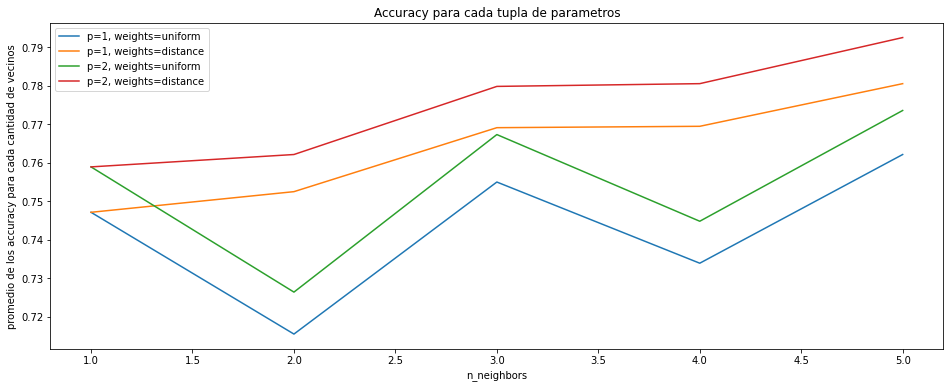

In [103]:
print('Accuracy para cada tupla de parametros')
list(zip(knn_gscv.cv_results_['params'], knn_gscv.cv_results_['mean_test_score']))

x1 = []
x2 = []
x3 = []
x4 = []
y1 = []
y2 = []
y3 = []
y4 = []


for i in range(0, len(knn_gscv.cv_results_['params'])):
    if(knn_gscv.cv_results_['params'][i]['p'] == 1 and knn_gscv.cv_results_['params'][i]['weights'] == 'uniform'):
        x1.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y1.append(knn_gscv.cv_results_['mean_test_score'][i])
    if(knn_gscv.cv_results_['params'][i]['p'] == 1 and knn_gscv.cv_results_['params'][i]['weights'] == 'distance'):
        x2.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y2.append(knn_gscv.cv_results_['mean_test_score'][i])
    if(knn_gscv.cv_results_['params'][i]['p'] == 2 and knn_gscv.cv_results_['params'][i]['weights'] == 'uniform'):
        x3.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y3.append(knn_gscv.cv_results_['mean_test_score'][i])
    if(knn_gscv.cv_results_['params'][i]['p'] == 2 and knn_gscv.cv_results_['params'][i]['weights'] == 'distance'):
        x4.append(knn_gscv.cv_results_['params'][i]['n_neighbors'])
        y4.append(knn_gscv.cv_results_['mean_test_score'][i])
    

fig, ax = plt.subplots()
ax.plot(x1, y1, label="p=1, weights=uniform")
ax.plot(x2, y2, label="p=1, weights=distance")
ax.plot(x3, y3, label="p=2, weights=uniform")
ax.plot(x4, y4, label="p=2, weights=distance")
ax.set_xlabel('n_neighbors')
ax.set_ylabel('promedio de los accuracy para cada cantidad de vecinos')
ax.legend()
plt.title('Accuracy para cada tupla de parametros')
plt.show()

#### 7.1.2: score obtenido para k-nearest neighbors

In [16]:
tuned_knn = KNeighborsClassifier(**best_params)
tuned_knn.fit(X_train, Y_train)
tuned_knn.score(X_test, Y_test)

0.7979166666666667

### 7.2: Support Vector Machines

In [17]:
svm_classifier = svm.SVC(max_iter=5000)

#### 7.2.2: cross validation para hallar los mejores hiperparámetros de la Support Vector Machine

In [18]:
param_grid = [
    {'C': [1], # poner [0.5, 1, 10, 100] para exp final
    'gamma': ['scale'], # poner ['scale', 1, 0.1, 0.01, 0.001, 0.0001] para exp final
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
]
#Default values are C=1 and gamma='scale'
svm_gscv = GridSearchCV(
    svm_classifier,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2
)
svm_gscv.fit(X_train, Y_train)

best_accuracy = svm_gscv.best_score_
best_params = svm_gscv.best_params_
print("Best accuracy is", best_accuracy)
print("For parameters", best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   9.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   9.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   9.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   9.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   9.6s


/home/administrador/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.6s


/home/administrador/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.5s


/home/administrador/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.6s


/home/administrador/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.6s


/home/administrador/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.5s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=  10.4s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=  10.5s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=  10.4s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=  10.5s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=  10.3s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   6.9s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   7.0s


/home/administrador/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   7.0s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   6.9s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   6.9s
Best accuracy is 0.8555357142857142
For parameters {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Accuracy para cada tupla de parametros


No handles with labels found to put in legend.


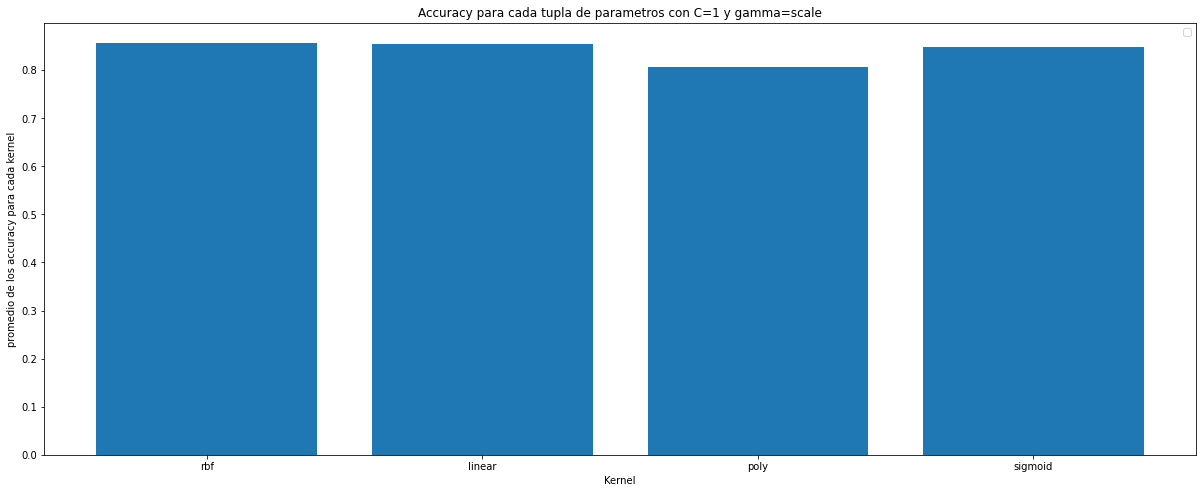

In [99]:
print('Accuracy para cada tupla de parametros')
list(zip(svm_gscv.cv_results_['params'], svm_gscv.cv_results_['mean_test_score']))

x = []
y = svm_gscv.cv_results_['mean_test_score']

for i in range(0, len(svm_gscv.cv_results_['params'])):
    x.append(svm_gscv.cv_results_['params'][i]['kernel'])

#fig, ax = plt.subplots()
#ax.plot(x, y)
#ax.set_xlabel('Kernel')
#ax.set_ylabel('promedio de los accuracy para cada kernel')
#ax.legend()
#plt.title('Accuracy para cada tupla de parametros con C=1 y gamma=scale')
#plt.show()


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_xlabel('Kernel')
ax.set_ylabel('promedio de los accuracy para cada kernel')
ax.legend()
plt.title('Accuracy para cada tupla de parametros con C=1 y gamma=scale')
plt.show()

plt.show()

#### 7.2.2: score obtenido para nuestra Support Vector Machine

In [20]:
tuned_svm = svm.SVC(**best_params)
tuned_svm.fit(X_train, Y_train)
tuned_svm.score(X_test, Y_test)

0.8616666666666667

### 7.3: Regresión Logística

In [21]:
lr_classifier = LogisticRegression()

#### 7.3.2: cross validation para hallar los mejores hiperparámetros de Regresión Logística

In [22]:
param_grid = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['liblinear']
    }

lr_gscv = GridSearchCV(
    lr_classifier,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2
)
lr_gscv.fit(X_train, Y_train)

best_accuracy = lr_gscv.best_score_
best_params = lr_gscv.best_params_
print("Best accuracy is", best_accuracy)
print("For parameters", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.000774263682681127, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.000774263682681127, penalty=l1, s

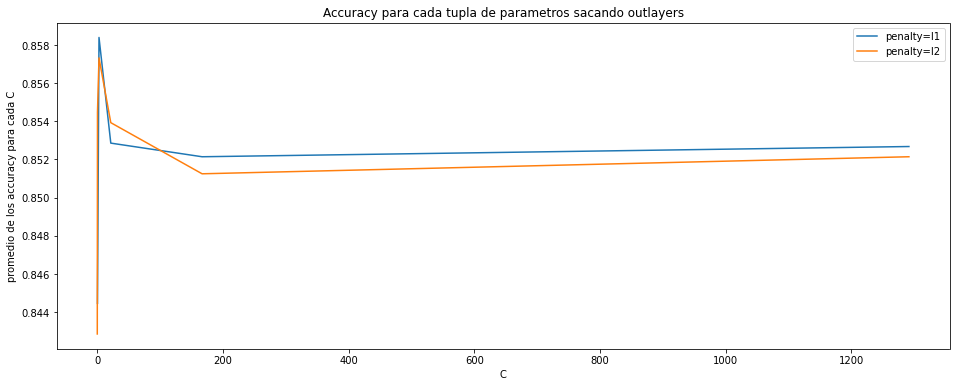

[0.50107143 0.81035714 0.50107143 0.82017857 0.50107143 0.82767857
 0.77196429 0.84285714 0.84446429 0.85446429 0.85839286 0.85732143
 0.85285714 0.85392857 0.85214286 0.85125    0.85267857 0.85214286
 0.85285714 0.8525    ]


In [78]:
#print('Accuracy para cada tupla de parametros')
list(zip(lr_gscv.cv_results_['params'], lr_gscv.cv_results_['mean_test_score']))
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#import numpy as np

x1 = []
x2 = []
y1 = []
y2 = []


for i in range(0, len(lr_gscv.cv_results_['params']) - 1):
    if(lr_gscv.cv_results_['params'][i]['penalty'] == 'l1' and lr_gscv.cv_results_['params'][i]['C'] < 2000):
        if(lr_gscv.cv_results_['mean_test_score'][i]> 0.84):
            x1.append(lr_gscv.cv_results_['params'][i]['C'])
            y1.append(lr_gscv.cv_results_['mean_test_score'][i])
    if(lr_gscv.cv_results_['params'][i]['penalty'] == 'l2' and lr_gscv.cv_results_['params'][i]['C'] < 2000):
        if(lr_gscv.cv_results_['mean_test_score'][i]> 0.84):
            x2.append(lr_gscv.cv_results_['params'][i]['C'])
            y2.append(lr_gscv.cv_results_['mean_test_score'][i])
    

fig, ax = plt.subplots()
ax.plot(x1, y1, label="penalty=l1")
ax.plot(x2, y2, label="penalty=l2")
ax.set_xlabel('C')
ax.set_ylabel('promedio de los accuracy para cada C')
ax.legend()
plt.title('Accuracy para cada tupla de parametros sacando outlayers')
plt.show()
#print(x)
print(lr_gscv.cv_results_['mean_test_score'])
#print(lr_gscv.cv_results_['mean_test_score'][0])
#print(lr_gscv.cv_results_['params'][1]['penalty'] == 'l2')
#print(y1)
#print(y2)

#### 7.3.3: score obtenido para la Regresión Logística

In [24]:
lr = LogisticRegression(**best_params)
lr.fit(X_train,Y_train)
score_lr = lr.score(X_test, Y_test)
score_lr

0.8670833333333333

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

RED NEURONAL

In [25]:
%run ANN.ipynb

epoch = 5
learning_rate = 0.005

network = [
  fullyConnectedLayer(495, 64,'random'),
  activationLayer(relu, relu_prime),
  fullyConnectedLayer(64, 32,'random'),
  activationLayer(relu, relu_prime),
  fullyConnectedLayer(32, 16,'random'),
  activationLayer(relu, relu_prime),
  fullyConnectedLayer(16, 1,'random'),
  activationLayer(sigmoid, sigmoid_prime),

  ]
X_train=X_train.reshape((5600, 1,495))
compile_(network,epoch,learning_rate,X_train,Y_train)
ratio = sum([y == np.round(predict(network, x)[0][0]) for x, y in zip(X_test, Y_test)]) / len(X_test)
error = sum([mse(y, predict(network, x)) for x, y in zip(X_test, Y_test)]) / len(X_test)
print('ratio: %.2f' % ratio)


ValueError: cannot reshape array of size 1915200 into shape (5600,1,495)

In [38]:
"""
TODO:

- Probar con otros valores (idealmente no arbitrarios) de MIN_FREQUENCY y MAX_FREQUENCY
- Hacer grafiquitos lindos
- Probar usando solo los títulos de la noticia, ignorar el texto. (DONE)
- Experimentar variando el max_iter tanto de SVM como de LogisticRegression
- Entender qué carajo son las iteraciones
- Experimentar cambiando la función kernel de SVM (poly, rbf, linear, sigmoid (Sigmoid Freud))
- Experimentar variando el tamano del conjunto de entrenamiento (train_set)
- Por defecto SVM tiene max_iter=-1 iteraciones y parece que no termina (converge?) nunca, pero por ahora no lo corrimos
más de 5 minutos, estaría bueno dejar corriéndolo un rato y ver si termina.

Resultados para recordar:
Hasta ahora SVM dio mejor con kernel=rbf (88,8% de accuracy con 10.000 iteraciones).
""" 

'\nTODO:\n\n- Probar con otros valores (idealmente no arbitrarios) de MIN_FREQUENCY y MAX_FREQUENCY\n- Hacer grafiquitos lindos\n- Probar usando solo los títulos de la noticia, ignorar el texto.\n'